# Large assignment 3

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_LargeAssignment3.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pyjags as pj

print('Using PyJAGS v{:s}'.format(pj.__version__))

plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=12)       # legend fontsize
plt.rc('figure', titlesize=30)      # fontsize of the figure title

Using PyJAGS v1.3.8


# 1. Ageing and cognitive decline

One of the topics that is studied extensively at the Donders Institute is the effect of ageing on cognition (for example, if you are interested: https://www.ru.nl/donders/research/theme-3-plasticity-memory/research-groups-theme-3/cognitive-aging/). It is generally accepted that (on average), performance on cognitive tasks decreases as we grow older. In this exercise, we'll use Bayesian modelling and Bayesian model comparison to explore this further. Note: although the data were generated specifically for this exercise (that is, they are not real measurements), the setting is not unrealistic.

One of the scores that measures cognitive performance is the [Rey–Osterrieth Complex Figure](https://en.wikipedia.org/wiki/Rey%E2%80%93Osterrieth_complex_figure) (ROCF) assessment, which asks participants to redraw a complicated line drawing from memory. In this assignment, we'll assume the ROCF score has been measured and stored for different people in the same age range ($50-80$), but for two different groups: The first is the `control` group, which consists of regularly ageing people. The second group is a group that has been instructed, starting at age 50, to exercise at least 2 times a week. We will refer to this group as the `active` group.

The question is of course: __Does an active lifestyle reduce the effects of ageing on cognitive decline?__

The following code snippet loads and plots the ROCF scores for this exercise.

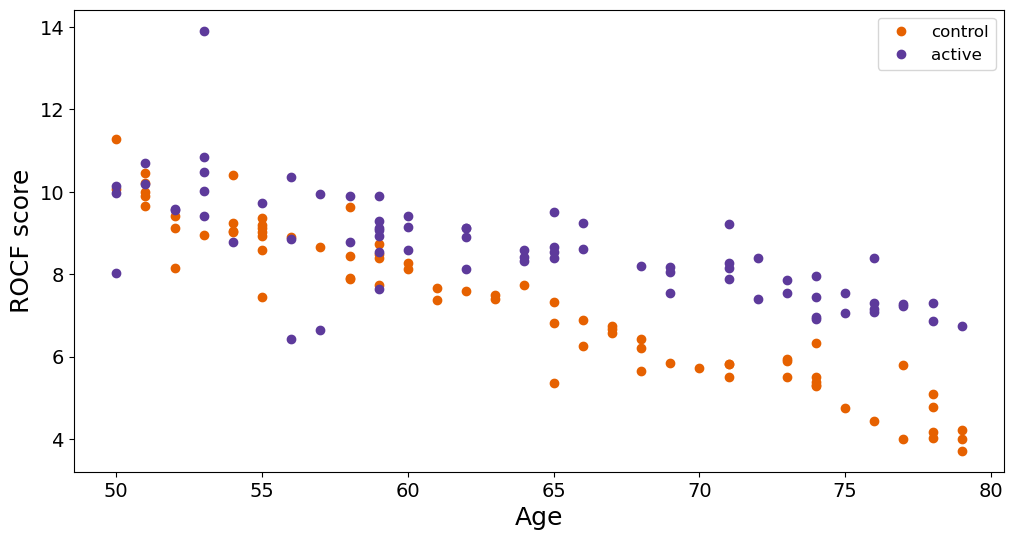

In [54]:
data = np.load('ROCF_data.npz')
x_control = data['x_control']
x_active = data['x_active']
y_control = data['y_control']
y_active = data['y_active']

labels = ['control', 'active']

plt.figure(figsize=(12, 6))
ax = plt.gca()
colors = ['#E66100', '#5D3A9B']

ax.plot(x_control, y_control, 'o', label=labels[0], color=colors[0])
ax.plot(x_active, y_active, 'o', label=labels[1], color=colors[1])
ax.set_xlabel('Age')
ax.set_ylabel('ROCF score')
ax.legend()

The approach to study this problem will, once more, be that of linear regression. Within that context, the research question translates into: __Is the difference between the slopes in linear regression of the control group, $\beta_1^c$ and the active group, $\beta_1^a$, nonzero?__

By looking at the data, there does appear to be a difference, although near the beginning (e.g. ages 50-60) there is still a lot of overlap.

Let's call this difference between the slopes $\delta=\beta_1^a - \beta_1^c$.

1. What is the null hypothesis ($m_0$), in terms of $\delta$?


_ANSWER:_ Null hypothesis is that $\delta$ is 0 (or insignificant). This means that there is no initial difference in the slopes for each linear regression line fitted to a group. This would mean that the rate of decline of cognitive function is roughly equal between the active and control group.

In our alternative hypothesis ($m_1$), the difference in slopes $\delta$ is unknown.

2. Write down a generative model that uses all observations $(x_i^c, y_i^c)_{i=1}^{n^c}$ and $(x_i^a, y_i^a)_{i=1}^{n^a}$ to learn the distribution over $\delta$. Note: this is simply two separate linear regressions, with the addition of the $\delta$ term. The superscripts $\cdot^a$ and $\cdot^c$ are used to indicate the active and the control group, respectively. As always, be mindful of which distributions make sense for which variable (and note that $\delta$ is a _deterministic_ variable, and hence is not assigned a distribution!). Check the examples of linear regression in Lecture 6 if you are unsure.

_ANSWER:_
The generative model, which describes two independent linear regressions for the control group (superscript $c$) and the active group (superscript $a$), is defined as follows:

**Priors:**
\begin{align*}
\beta_0^c &\sim \mathcal{N}(10, 10) && \text{(Intercept for control group; variance is } 1/0.1=10) \\
\beta_1^c &\sim \mathcal{N}(0, 10) && \text{(Slope for control group; variance is } 1/0.1=10) \\
\sigma^c &\sim \text{Uniform}(0.01, 500) && \text{(Standard deviation for control group)} \\
\tau^c\mid\sigma^c &= \frac{1}{(\sigma^c)^2} && \text{(Precision for control group)} \\
\\
\beta_0^a &\sim \mathcal{N}(10, 10) && \text{(Intercept for active group; variance is } 1/0.1=10) \\
\beta_1^a &\sim \mathcal{N}(0, 10) && \text{(Slope for active group; variance is } 1/0.1=10) \\
\sigma^a &\sim \text{Uniform}(0.01, 500) && \text{(Standard deviation for active group)} \\
\tau^a\mid\sigma^a &= \frac{1}{(\sigma^a)^2} && \text{(Precision for active group)}  \\
\\
\end{align*}

**Likelihood:**
For the control group observations $(x_i^c, y_i^c)$:
\begin{align*}
\mu_i^c &= \beta_0^c + \beta_1^c x_i^c && \text{for } i = 1, \ldots, n^c \\
y_i^c &\sim \mathcal{N}(\mu_i^c, \tau^c) && \text{for } i = 1, \ldots, n^c
\end{align*}
For the active group observations $(x_j^a, y_j^a)$:
\begin{align*}
\mu_j^a &= \beta_0^a + \beta_1^a x_j^a && \text{for } j = 1, \ldots, n^a \\
y_j^a &\sim \mathcal{N}(\mu_j^a, \tau^a) && \text{for } j = 1, \ldots, n^a
\end{align*}

**$\delta$ (deterministic):**
$$
\delta = \beta_1^a - \beta_1^c
$$
Here, $n^c$ is the number of observations in the control group and $n^a$ is the number of observations in the active group.

3. Draw the graphical model that corresponds to your generative model. Make sure to pay attention to the correct repetition/indexing/shading and so on.

_ANSWER:_ 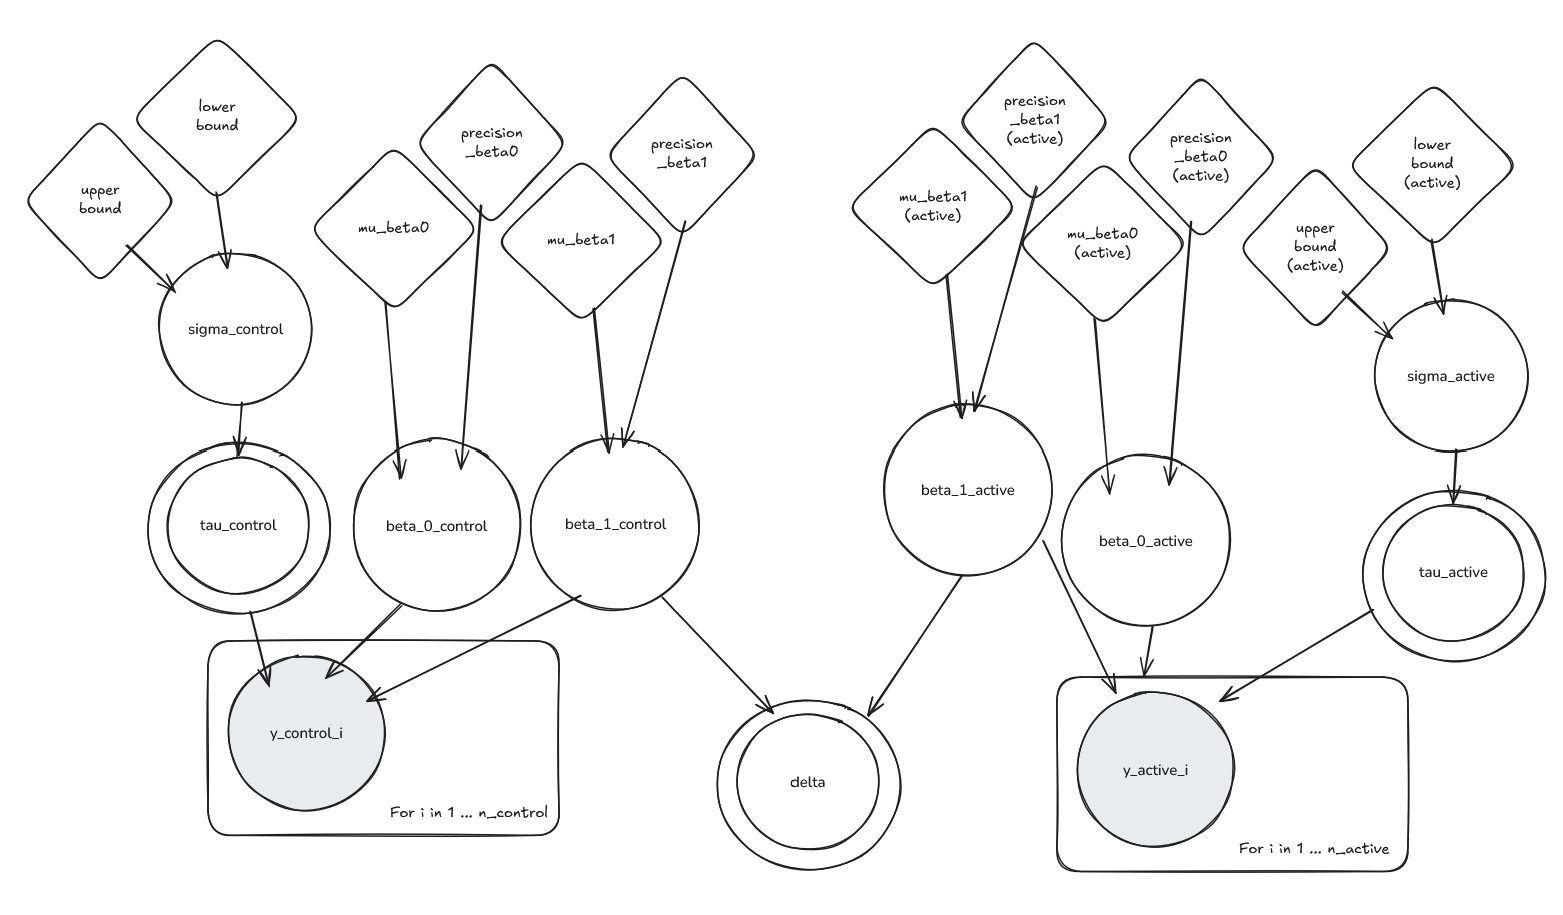

As we saw in Large Assignment #2 and Lectures 7 & 8, there are multiple ways of figuring out the answer to this question. This time, we shall use the Region of Practical Equivalence (ROPE) approach.

4. The first step is to implement the model in JAGS and see if everything went alright - that is, we can once more plot the posterior expectations of $\mu_i^g = \beta_0^g + \beta_1^g x_i^g$, with $g\in\{a, c\}$. These expectations should be pretty good fits through the observed data points.

Much of the code for the visualization was already provided in Lecture 6 and Large Assignment 1, and is partially repeated below for your convenience.

_ANSWER:_

In [55]:
%%time

# b[1, :] is control
# b[2, :] is active
# b[:, 1] is y intercept
# b[:, 2] is slope

code = '''
model{
    for (k in 1:2){
        sigma[k] ~ dunif(0.01, 500)
        tau[k] <- 1/pow(sigma[k], 2)
        
        b[k, 1] ~ dnorm(10, 0.1)
        b[k, 2] ~ dnorm(0, 0.1)
    }

    for (i in 1:n_control) { 
        y_control[i] ~ dnorm(b[1,1] + b[1,2] * x_control[i], tau[1]) 
        }

    for (j in 1:n_active) { 
        y_active[j] ~ dnorm(b[2,1] + b[2,2] * x_active[j], tau[2]) 
        }
        
    delta <- b[2, 2] - b[1, 2]
}
'''

data = dict(x_control=x_control,
            x_active=x_active,
            y_control=y_control,
            y_active=y_active,
            n_control=len(x_control),
            n_active=len(x_active))
num_samples = 10_000
num_chains = 4

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=["b", "sigma", "tau", "delta"])

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:02, remaining 0:00:00
CPU times: user 2.82 s, sys: 50.3 ms, total: 2.87 s
Wall time: 2.87 s


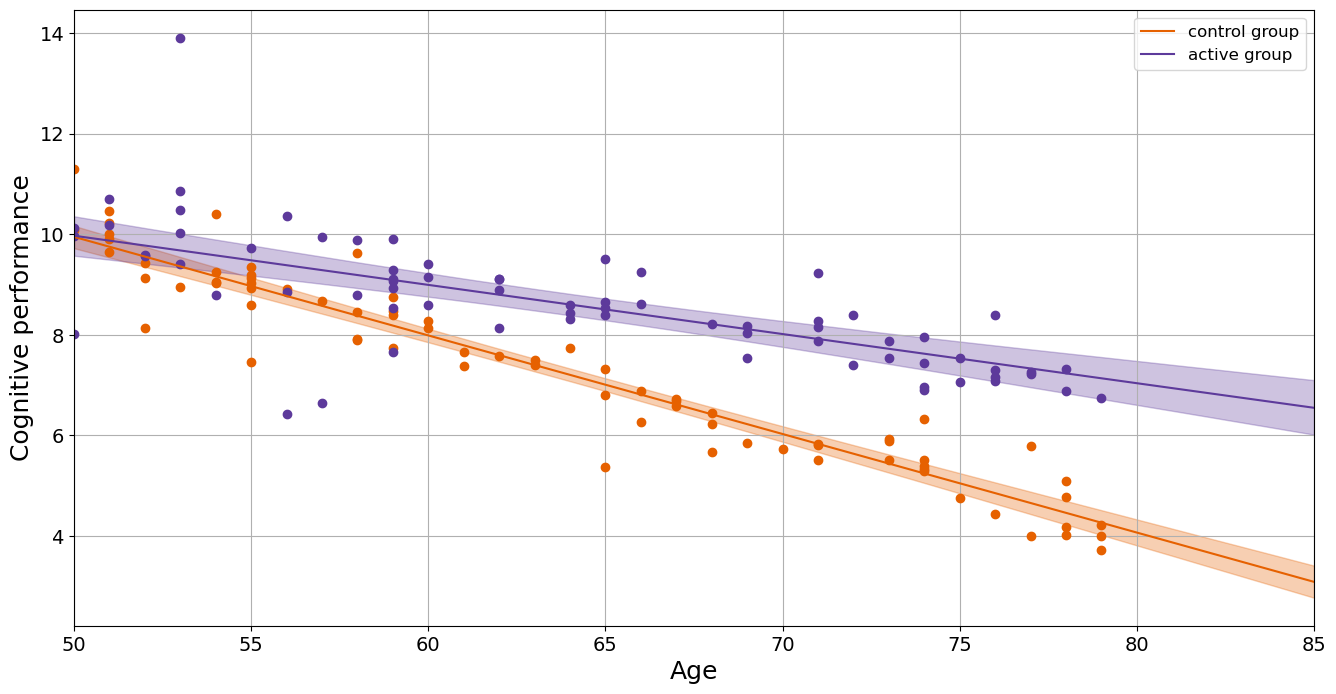

In [56]:
plt.figure(figsize=(16, 8))
ax = plt.gca()

ax.plot(x_control, y_control, 'o', color=colors[0])
ax.plot(x_active, y_active, 'o', color=colors[1])

m = 100
x_range = np.linspace(50, 85, num=m)
# Rename the variables to match your JAGS code!

w0_samples = np.reshape(samples['b'][:, 0], newshape=(2, num_samples*num_chains))
w1_samples = np.reshape(samples['b'][:, 1], newshape=(2, num_samples*num_chains))

x_repeat = np.repeat(x_range[:, np.newaxis], num_samples*num_chains, axis=1).T

for k in range(2):
    w0_repeat = np.repeat(w0_samples[k][:, np.newaxis], m, axis=1)
    w1_repeat = np.repeat(w1_samples[k][:, np.newaxis], m, axis=1)
    mu_samples = w0_repeat + w1_repeat*x_repeat

    mu_exp = mu_samples.mean(axis=0)
    mu_lower = np.percentile(mu_samples, 2.5, axis=0)
    mu_upper = np.percentile(mu_samples, 97.5, axis=0)

    ax.plot(x_range, mu_exp, color=colors[k],
            label=f'{labels[k]} group')
    ax.fill_between(x_range,
                    mu_lower,
                    mu_upper, color=colors[k], alpha=0.3)
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Cognitive performance')
ax.set_xlim([x_range[0], x_range[-1]]);
ax.grid(True)

Once you are happy with the training of your model, we can continue with finding the answer to the research question. However, this time we have chosen the ROPE approach to model comparison / hypothesis testing. It is important that we define the ROPE __before__ we actually look at the posterior distribution of $\delta$, because otherwise we could just conveniently pick the ROPE to match our political agenda. __THIS. IS. VERY. BAD.__

To choose a ROPE, we have to figure out what we consider 'practically equivalent' with the null hypothesis value (which you determined in question #1). First, we need to have a bit of an intuition of what kind of values we can expect for the slopes $b_1^a$ and $b_1^c$, because that will also inform us about what a sensible difference is. By just looking at the data points, we can see that, for example, the control group drops about 6 ROCF points when age increases by 30, which gives us an educated guess of $\beta_1^c\approx 6/30=0.2$.

5. Determine your choice of the ROPE (the bounds of the interval around the value indicated by the null hypothesis). Note: there is not really a right answer here, but many answers could be wrong (for example, a ROPE of $[25, 30]$ seems weird to me). The point is that you think about what values for $\delta$ you expect, and consequently which values you think are pretty much equivalent to the null hypothesis value.





_ANSWER:_ We want to determine the practical significance of the difference in cognitive decline rates, $\delta = \beta_1^a - \beta_1^c$, between the active and control groups. If we consider a reasonable 30-year window and define a cumulative difference of $M=1$ ROCF point over this duration as the threshold for practical significance (below which difference are probably unlikely to affect clinical recommendations or be noticable), we get a ROPE for the annual slope difference $\delta$ of:
$$ \text{ROPE for } \delta = \left[ -\frac{1}{30}, +\frac{1}{30} \right] \text{ points/year} $$
This interval is approximately $[-0.0333, +0.0333]$ points/year. 

In [57]:
ROPE = [-0.0333, 0.0333]

5. Make a figure showing the posterior distribution of the variable we are interested in, that is, show $p(\delta \mid \mathbf{x}^c, \mathbf{y}^c, \mathbf{x}^a, \mathbf{y}^a)$.

_ANSWER:_ Done all in one figure (hope that's alright)

6. Determine the 95% HDI of $p(\delta \mid \mathbf{x}^c, \mathbf{y}^c, \mathbf{x}^a, \mathbf{y}^a)$ and indicate it clearly on top of your figure from the previous question (for example, with a horizontal line from the left bound of the HDI to the right bound of the HDI).

_ANSWER:_ Done all in one figure below.

7. Add your ROPE interval to the figure, using `ax.axvspan(...)` and `ax.axvline(...)`. Now use slide #6 from lecture 8 to answer the original research question. Does the active lifestyle have an effect in slowing down cognitive decline?

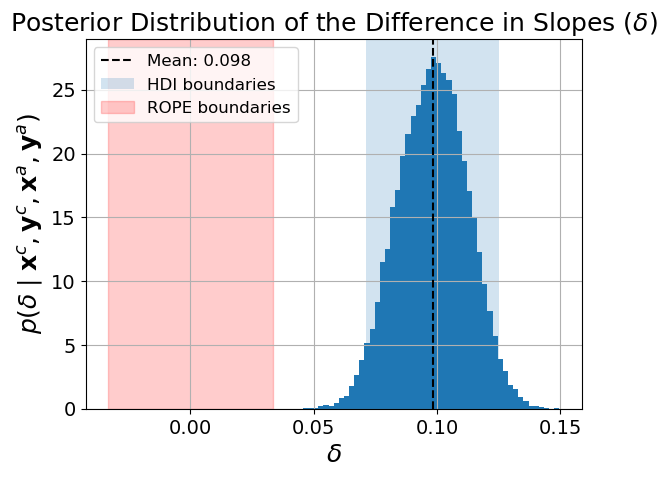

In [58]:
def get_hdi(s, intv=0.95):
    s_sorted = np.sort(s)
    n = len(s_sorted)
    num_samples_in_hdi = int(n * intv)
    num_possible_hdis = n - num_samples_in_hdi 

    bottom_idx = np.arange(0, num_possible_hdis)
    top_idx = bottom_idx + num_samples_in_hdi

    assert all(top_idx - bottom_idx == num_samples_in_hdi)

    s_bottom = s_sorted[bottom_idx]
    s_top = s_sorted[top_idx]
    diffs = s_top - s_bottom
    min_diff_idx = np.argmin(diffs)

    s_bottom_hdi = s_bottom[min_diff_idx]
    s_top_hdi = s_top[min_diff_idx]
    
    return s_bottom_hdi, s_top_hdi

delta_samples = samples["delta"].flatten()
hdi_bottom, hdi_top = get_hdi(delta_samples)

plt.hist(delta_samples, bins=50,density=True)
plt.axvline(np.mean(delta_samples), color='k', linestyle='dashed', linewidth=1.5, label=f'Mean: {np.mean(delta_samples):.3f}')
plt.axvspan(hdi_bottom, hdi_top, alpha=0.2, label="HDI boundaries")

plt.xlabel(r'$\delta$')
plt.ylabel(r'$p(\delta \mid \mathbf{x}^c, \mathbf{y}^c, \mathbf{x}^a, \mathbf{y}^a)$')
plt.grid(True)
plt.axvspan(ROPE[0], ROPE[-1], color='red', alpha=0.2, label='ROPE boundaries')
plt.title('Posterior Distribution of the Difference in Slopes ($\delta$)')
plt.legend()

_ANSWER:_ The mean of the posterior is approximately $0.097$ points/year. When compared against the ROPE of $[-1/30, +1/30]$ (approximately $[-0.0333, +0.0333]$ points/year), the majority of the posterior probability mass for $\delta$, including the 95% HDI, lies well above the upper bound of this ROPE. This is strong evidence that there is a significant positive difference, suggesting that the active group experiences a slower rate of cognitive decline compared to the control group (according to the defined ROPE though).


## Note

If the fact that we draw a conclusion based on a fairly arbitrary ROPE makes you uneasy, then we agree. At the same time, if we used e.g. the Bayes factor approach (through Savage-Dickey or otherwise), the decision would depend on our choices of priors. The bottom line is that everything is, in the end, subjective.

A frequentist approach would implicitely assume $\mathcal{N}(0, \infty)$ priors on the regression coefficients, which is uninformative, but not reasonable. Neither statistical framework gets us a free lunch.

---

# 2. CO2 measurements at the Mauna Loa observatory

[The Mauna Loa observatory](https://gml.noaa.gov/obop/mlo/) is a research facility that measures all sorts of atmospheric properties, such as CO2 concentration (in parts-per-million, ppm). These data form a _timeseries_ (which is a fancy word for a regression problem where $x$ represents time).

The code below loads and visualizes this famous dataset:

In [59]:
import pandas as pd

## Load:
data = pd.read_csv('co2_mm_mlo.txt', delim_whitespace=True,
                   usecols=[0, 1, 2, 3], names=['Year', 'Month', 'Time', 'CO2'],
                   decimal=',')
x = data['Time'].to_numpy()  # in months
y = data['CO2'].to_numpy()   # CO2 per month

/tmp/ipykernel_1986/202054772.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('co2_mm_mlo.txt', delim_whitespace=True,


This type of timeseries often can be described by a number of different components. For instance, there is a clear _seasonal_ trend, representing the systematic fluctuations over the seasons as a kind of sine wave. In addition, there is the _upward_ trend (which is what we as a society need to worry about a lot).

In terms of statistical modelling, there are a number of important topics when it comes to timeseries:

* Can we predict the future?
* What kind of trends are present in the data?

First, we will take a look at the first topic, that of prediction. In order to figure out if our models make any sense, we will split the data into a _train set_ (all data up to [not including] 2010) and a _test set_ (all data starting at 2010):

**Note**: I make a distinction between the actual time (1990, 1990.1, ...) $t$ and the index $x$ (1, 2, ...). In theory we could use both as our predictors, but in practice it is easier to use the index $x$, because otherwise our sampler starts so very far away from the actual posterior distribution. So keep in mind: use $x$ to train your model and make predictions, but use $t$ for plotting.

In [60]:
index_of_2010 = 622  # The row in the file where year 2010 starts

time_train = x[:index_of_2010]
x_train = np.arange(len(time_train))
y_train = y[:index_of_2010]

time_test = x[index_of_2010:]
x_test = np.arange(len(time_test)) + len(time_train)
y_test = y[index_of_2010:]

n_train = len(x_train)
n_test = len(x_test)

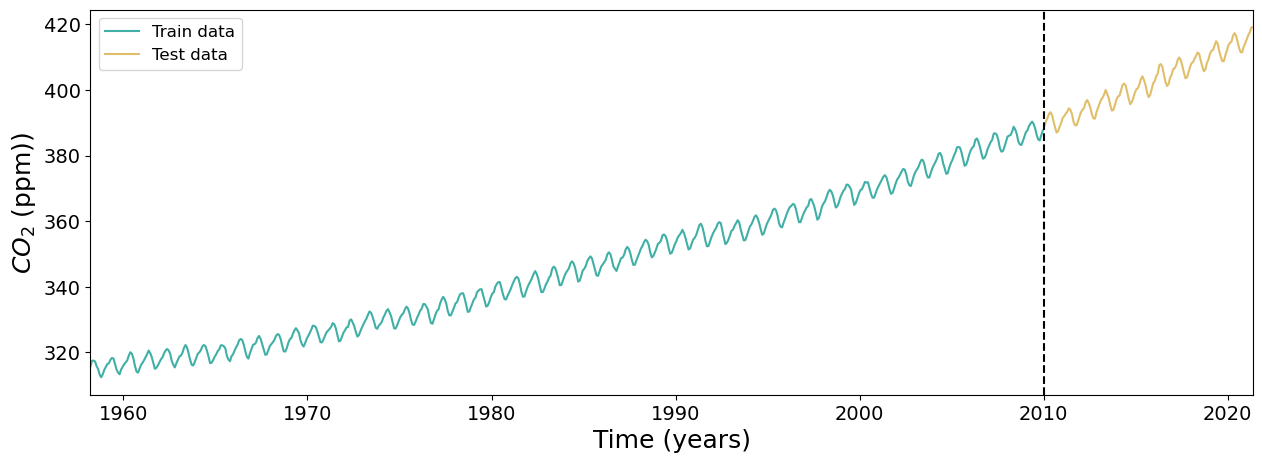

In [61]:
# Visualize data

colors = ['#40B0A6', '#E1BE6A']

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)]);

In this exercise, you'll construct three Bayesian models that you'll train on (`x_train`, `y_train`) and evaluate using (`x_test`, `y_test`).

**Note**: the models are extensions of each other; make sure the first is correct, then creating the extensions will be much easier.

### The linear model

The first model to try is a linear regression approach, which you have implemented/seen several times before.

1. Implement a Bayesian linear regression model, and learn the (approximated) posterior distribution $p(\beta_0, \beta_1, \sigma \mid \mathbf{x}_{\text{train}}, \mathbf{y}_{\text{train}})$. Feel free to re-use your (own!) JAGS code from previous exercises, or check the lecture slides. Make a figure with three subplots, one showing $\beta_0$, one showing $\beta_1$, and the last one showing $\sigma$. Do your plots seem sensible? Make sure to keep track of $\mu_i = \beta_0 + \beta_1 x_i$, you will need it later.

_ANSWER:_

In [62]:
%%time

code = '''
model{
    sigma ~ dunif(0.00001, 500)
    tau <- 1/pow(sigma, 2)
    b[1] ~ dnorm(320, 0.01)
    b[2] ~ dnorm(2, 0.01)
    

    for (i in 1:n_train) { 
        y_train[i] ~ dnorm(b[1] + b[2] * x_train[i], tau) 
        }
}
'''

data = dict(x_train=x_train,
            y_train=y_train,
            n_train=n_train)
num_samples = 10_000
num_chains = 4

m_linear = pj.Model(code=code, data=data, chains=num_chains)
samples_linear = m_linear.sample(num_samples, vars=["b", "sigma", "tau"])

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:07, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:07, remaining 0:00:00
CPU times: user 7.88 s, sys: 0 ns, total: 7.88 s
Wall time: 7.88 s


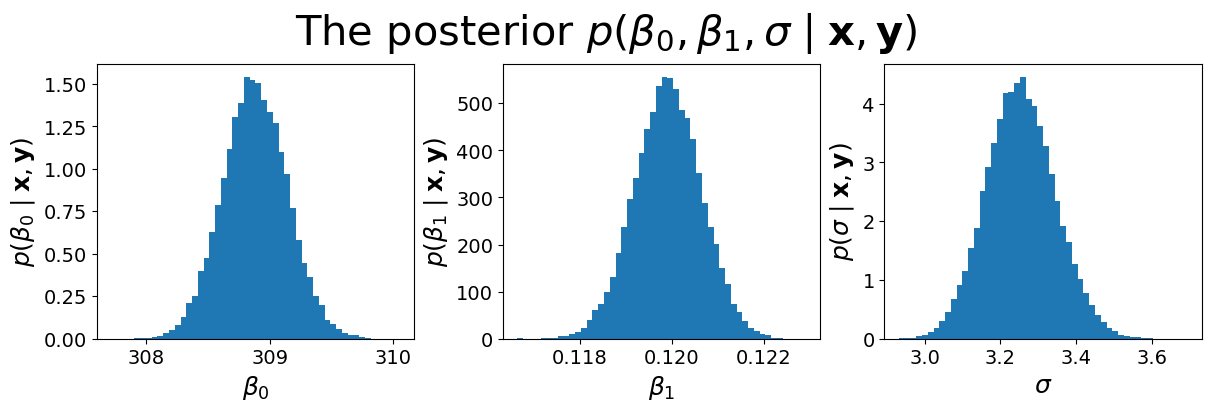

In [63]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), constrained_layout=True)
beta0 = samples_linear["b"][0].flatten()
beta1 = samples_linear["b"][1].flatten()
sigma = samples_linear["sigma"].flatten()

axes[0].hist(beta0, density=True, bins=50)
axes[0].set_xlabel(r'$\beta_0$')
axes[0].set_ylabel(r'$p(\beta_0 \mid \mathbf{x}, \mathbf{y}) $')

axes[1].hist(beta1, density=True, bins=50)
axes[1].set_xlabel(r'$\beta_1$')
axes[1].set_ylabel(r'$p(\beta_1 \mid \mathbf{x}, \mathbf{y}) $')

axes[2].hist(sigma, density=True, bins=50)
axes[2].set_xlabel(r'$\sigma$')
axes[2].set_ylabel(r'$p(\sigma \mid \mathbf{x}, \mathbf{y}) $')

plt.suptitle(r'The posterior $p(\beta_0, \beta_1, \sigma \mid \mathbf{x}, \mathbf{y})$');

The next task is to use this model to _predict_ what happened with the CO2 concentrations after 2010. In Bayesian terms, that means we want the posterior predictive distribution

$$
p(y^* \mid \mathbf{x}_{\text{train}}, \mathbf{y}_{\text{train}}) = \int\int\int p(y^* \mid \beta_0, \beta_1, \sigma, x^*) p(\beta_0, \beta_1, \sigma \mid \mathbf{x}_{\text{train}}, \mathbf{y}_{\text{train}})\, \text{d}\beta_0 \text{d}\beta_1 \text{d}\sigma \enspace.
$$

Here, $y^*$ indicates the CO2 concentrations at timepoint $x^*$, which is a point **not** in our training set.

Of course, we will not exactly solve this difficult triple integral, but we use JAGS to make an MCMC-based approximation. This is quite straightforward:

2. Copy your JAGS code to a new code cell. In your JAGS code you probably have a for loop similar to `for (i in 1:n_train) {...}`. Within this loop, you describe `y_train[i] ~ ...`. You now need to create an additional loop, but this one describes the **predicted** points. It is a loop over the points that we have not trained on: `for (j in 1:n_test) {...}`. **Important**: Do not provide `y_test` as data to JAGS, that would be cheating. Instead, sample `y_predict[j] ~ ...` and track JAGS' predictions. Your `samples['y_predict']` object should have shape `(n_test, num_samples, num_chains)`.

_ANSWER:_

In [64]:
%%time

code = '''
model{
    sigma ~ dunif(0.00001, 500)
    tau <- 1/pow(sigma, 2)
    b[1] ~ dnorm(320, 0.01)
    b[2] ~ dnorm(2, 0.01)
    

    for (i in 1:n_train) { 
        y_train[i] ~ dnorm(b[1] + b[2] * x_train[i], tau) 
        }
        
    for (i in 1:n_test) { 
        y_predict[i] ~ dnorm(b[1] + b[2] * x_test[i], tau) 
        }  

}
'''

# Note: do not pass y_test to the JAGS model, that would be cheating!
data = dict(x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            n_train=n_train,
            n_test=n_test)
num_samples = 10_000
num_chains = 4

m_linear = pj.Model(code=code, data=data, chains=num_chains)
samples_linear = m_linear.sample(num_samples, vars=["b", "sigma", "y_predict"])

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 39200 of 40000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:08, remaining 0:00:00
CPU times: user 9.18 s, sys: 60.1 ms, total: 9.24 s
Wall time: 9.23 s


3. Copy the data visualization code and plot in addition the mean estimated $\mu_i$ over the training range. Furthermore, compute and visualize the mean and 95% HDI of the posterior predictive distribution. What is the expected CO2 concentration at the final observation (May 2021)?

_ANSWER:_ The expected CO2 concentration in May 2021 is $\approx 400$, which is significantly lower than the real estimate, which is $\approx 420$.

Predicted CO2 on May 2021: 399.7712046494222


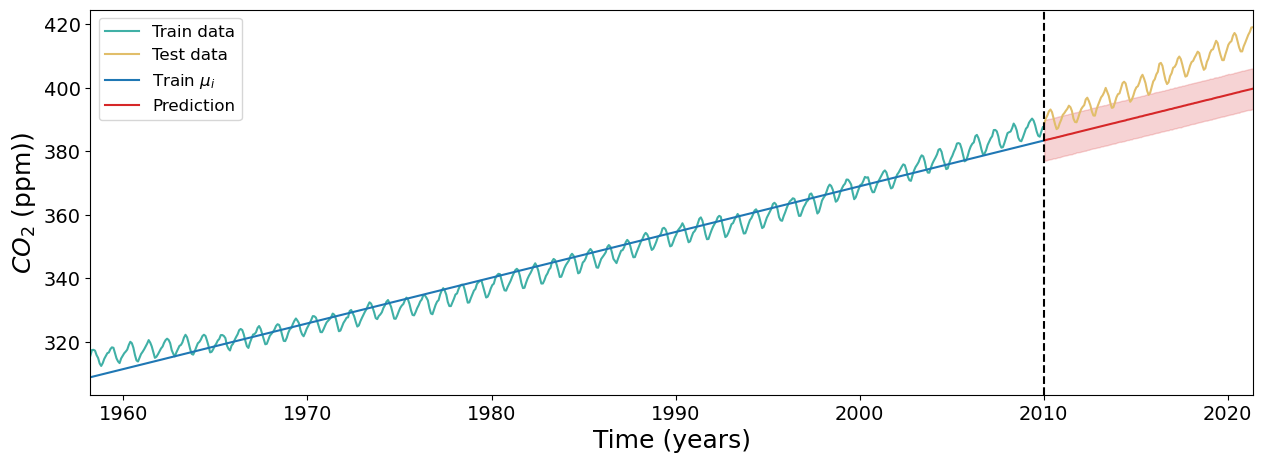

In [65]:
beta0 = samples_linear["b"][0].flatten() # shape num_samples * num_chains
beta1 = samples_linear["b"][1].flatten() # shape num_samples * num_chains
sigma = samples_linear["sigma"].flatten() # shape num_samples * num_chains
mu_samples = beta0[:, np.newaxis] + np.matmul(beta1[:, np.newaxis], x_train[:, np.newaxis].T) # shape: num_samples * num_chains x num_train = num_samples * num_chains x 1 + num_samples * num_chains x 1 * 1 x num_train
mu_exp = mu_samples.mean(axis=0)

y_predict = np.reshape(samples_linear["y_predict"], newshape=(-1, num_samples* num_chains))
y_predict_mean = np.mean(y_predict, axis=-1)
y_predict_lb = np.percentile(y_predict, 2.5, axis=1)  # lower bound of HDI
y_predict_ub = np.percentile(y_predict, 97.5, axis=1)  # upper bound of HDI

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_exp, color='tab:blue',
        label='Train $\mu_i$')

ax.plot(time_test, y_predict_mean, color='tab:red', label='Prediction')
ax.fill_between(time_test, y_predict_lb, y_predict_ub, color='tab:red',
                alpha=0.2)

ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)]);

print('Predicted CO2 on May 2021:', y_predict_mean[-1])

The 95% HDI shows a nice and smooth interval, but the individual samples can be quite noisy.

4. Make a new figure that shows, instead of the 95% HDI, 5 randomly chosen samples of $\mathbf{y}_{\text{test}}$. Note that each sample is a vector of length 137, ranging from January 2010 to May 2021.

_ANSWER:_

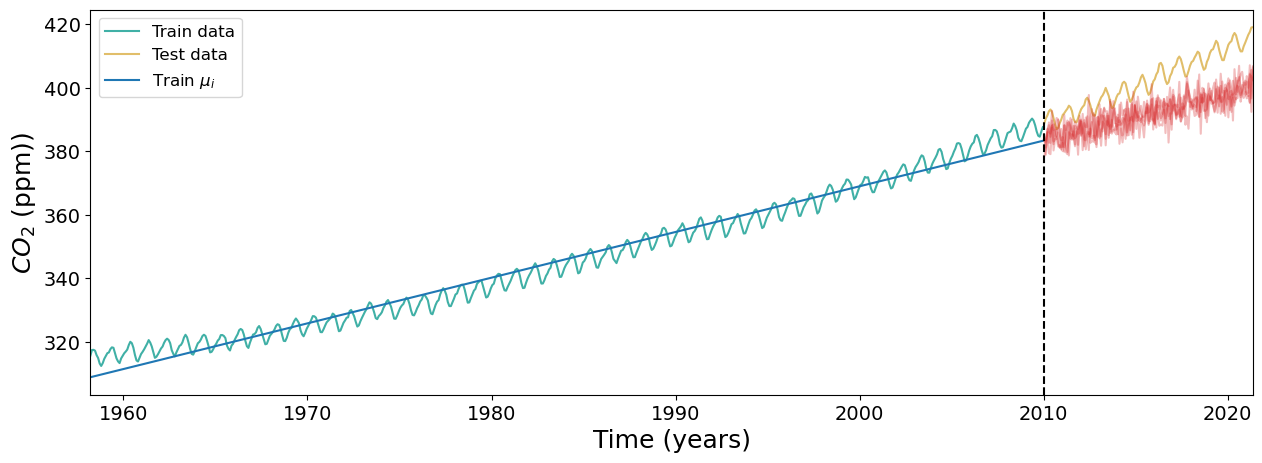

In [67]:
y_predict_samples = np.reshape(samples_linear["y_predict"], newshape=(-1, num_chains * num_samples))


plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_exp, color='tab:blue',
        label='Train $\mu_i$')

# pick 5 random samples
for i in np.random.randint(num_samples*num_chains, size=5):
    ax.plot(time_test, y_predict_samples[:, i], color='tab:red', alpha=0.3)

ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)]);

With the naked eye, we already know that our predictions are imperfect. We can quantify this into a (distribution of a) single number, so that we can later see whether changes to our model improve our predictions. One of the metrics to do this is the Mean Absolute Percentage Error (MAPE):

$$
  MAPE(\mathbf{y}^*, \mathbf{y}_{\text{test}}) = \frac{1}{n} \sum_{i=1}^n \frac{|y^*_i - y_{\text{test},i}|}{y_{\text{test},i}} \enspace.
$$

**(The lower the better!)**

The code below implements the calculation of the MAPE score for your predictions. The result is a distribution over MAPE scores, as we have a different score for every sample of the posterior predictive distribution.

5. Create the variable `y_predict_samples` from your MCMC output if you haven't already, and make sure it has shape `(n_test, num_chains*num_samples)`, then run the code below to make the histogram of MAPE scores.

_ANSWER:_

Shape of y_predict_samples: (137, 40000)


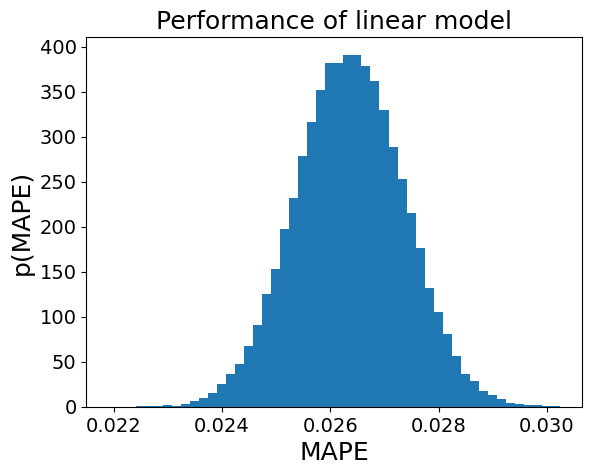

In [68]:
def mape(y_pred_):
    return np.mean(np.abs(y_pred_ - y_test) / y_test)

#

print('Shape of y_predict_samples:', y_predict_samples.shape)

# make sure y_predict_samples has the correct shape!
mape_scores = np.apply_along_axis(mape, 1, y_predict_samples.T)

plt.figure()
plt.hist(mape_scores, density=True, bins=50)
plt.xlabel('MAPE')
plt.ylabel('p(MAPE)')
plt.title('Performance of linear model');

### The linear + seasonal model

In the previous steps, we use Bayesian linear regression to determine the CO2 predictions. That means something along the lines of (omitting priors for now):

$$
\begin{align*}
    \mu_i \mid \beta_0, \beta_1, x_i &= \beta_0 + \beta_1 x_i && i=1,\ldots,n\\
    y_i \mid \mu_i, \sigma & \sim \mathcal{N}(\mu_i, \sigma)  && i=1,\ldots,n\enspace.
\end{align*}
$$

It is straightforward to add the seasonal component of the observations into this model. In that case, we have:

$$
\begin{align*}
    \mu_i \mid \beta_0, \beta_1, \beta_2, \phi, x_i &= \beta_0 + \beta_1 x_i + \beta_2 \sin(2\pi / 12 x_i + \phi)  && i=1,\ldots,n\\
    y_i \mid \mu_i, \sigma & \sim \mathcal{N}(\mu_i, \sigma)  && i=1,\ldots,n\enspace.
\end{align*}
$$

The term $\beta_2$ is the coefficient that indicates how strong the seasonal influence is. The period of the sine wave is 12 months (hence $2\pi/12$), and $\phi$ is the _phase_ that tells us where the sine wave is at $x=0$. This is an additional parameter to learn, as we do not know exactly what this value should be.

6. Copy your previous model into the code block below, and add the seasonal part. For $\beta_2$, it makes sense to use the same priors as for the other regression coefficients. The phase $\phi$ is a value between 0 and the period of the sine wave (12) - what would be a sensible prior distribution here? Run your code and make the same figure as for subquestion 3, showing the actual observations, the mean $\mu_i$ over the range of the training data, and the posterior predictive distribution using its mean and its 95% HDI, over the range of the test data.

**Note**: This probably takes a bit longer to sample!

_ANSWER:_ We assume a pattern that repeats yearly. The phase shift controls at which part of the sinusoidal curve the pattern "starts". After 12 months the pattern repeats, so it only makes sense to sample between 0 and 12. Since we have no prior information here, we sample uniformly.

In [69]:
%%time

code = '''
model{
    sigma ~ dunif(0.00001, 500)
    tau <- 1/pow(sigma, 2)
    b[1] ~ dnorm(320, 0.01)  
    b[2] ~ dnorm(2, 0.01)    
    b[3] ~ dnorm(5, 0.01)    

    phi ~ dunif(0, 12)       
    
    for (i in 1:n_train) { 
        mu_train[i] <- b[1] + b[2] * x_train[i] + b[3] * sin(2 * 3.1415926535 / 12 * (x_train[i] + phi))
        y_train[i] ~ dnorm(mu_train[i], tau) 
    }
        
    for (i in 1:n_test) { 
        mu_predict[i] <- b[1] + b[2] * x_test[i] + b[3] * sin(2 * 3.1415926535 / 12 * (x_test[i] + phi))
        y_predict[i] ~ dnorm(mu_predict[i], tau) 
    }  
}
'''

data = dict(x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            n_train=n_train,
            n_test=n_test)
num_samples = 10_000
num_chains = 4

m_seasonal = pj.Model(code=code, data=data, chains=num_chains)
samples_seasonal = m_seasonal.sample(num_samples, vars=["y_predict", "b", "sigma", "phi"])

adapting: iterations 4000 of 4000, elapsed 0:00:04, remaining 0:00:00
sampling: iterations 7940 of 40000, elapsed 0:00:08, remaining 0:00:32
sampling: iterations 18336 of 40000, elapsed 0:00:16, remaining 0:00:19
sampling: iterations 24032 of 40000, elapsed 0:00:24, remaining 0:00:16
sampling: iterations 34160 of 40000, elapsed 0:00:33, remaining 0:00:06
sampling: iterations 40000 of 40000, elapsed 0:00:38, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:38, remaining 0:00:00
CPU times: user 42.3 s, sys: 79 ms, total: 42.4 s
Wall time: 42.4 s


(1958.2027, 2021.375)

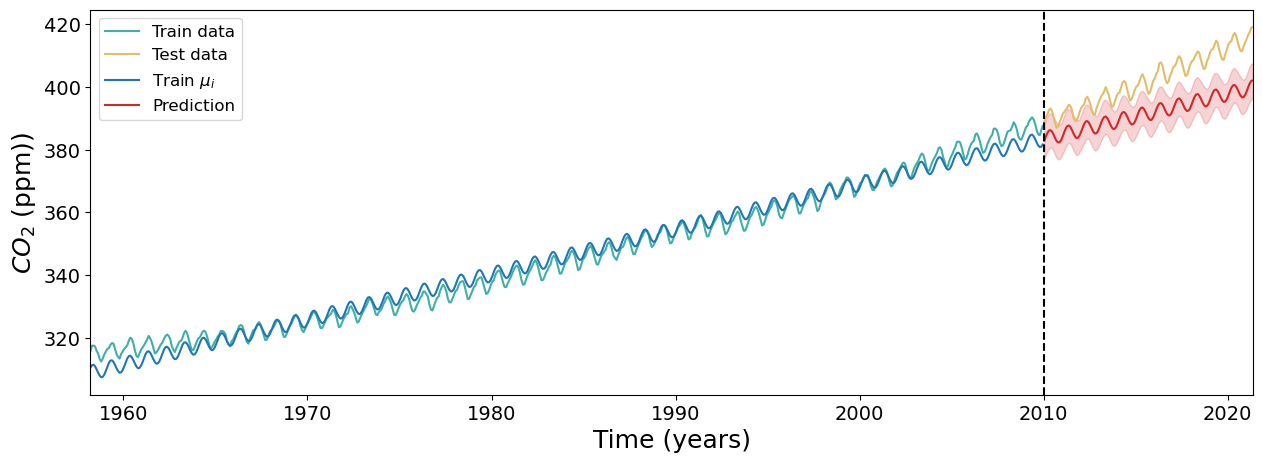

In [70]:
beta0 = samples_seasonal["b"][0].flatten() # shape num_samples * num_chains
beta1 = samples_seasonal["b"][1].flatten() # shape num_samples * num_chains
beta2 = samples_seasonal["b"][2].flatten()
sigma = samples_seasonal["sigma"].flatten() # shape num_samples * num_chains
phi = samples_seasonal["phi"].flatten()
angular_freq = 2*3.14159/12
linear_part = beta0[:, np.newaxis] + beta1[:, np.newaxis] * x_train[np.newaxis, :] # shape: num_samples * num_chains x num_train (num_samples * num_chains x 1 + num_samples * num_chains x 1 @ 1 x num_train)
seasonal_part = beta2[:, np.newaxis] * np.sin(angular_freq * (x_train[np.newaxis, :] + phi[:, np.newaxis]))
mu_samples = linear_part + seasonal_part

mu_exp = mu_samples.mean(axis=0)

y_predict = np.reshape(samples_seasonal["y_predict"], newshape=(-1, num_samples* num_chains))
y_predict_mean = np.mean(y_predict, axis=-1)
y_predict_lb = np.percentile(y_predict, 2.5, axis=1)  # lower bound of HDI
y_predict_ub = np.percentile(y_predict, 97.5, axis=1)  # upper bound of HDI

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_exp,
        color='tab:blue', label='Train $\mu_i$')
ax.plot(time_test, y_predict_mean, color='tab:red', label='Prediction')
ax.fill_between(time_test, y_predict_lb, y_predict_ub, color='tab:red',
                alpha=0.2)

ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)])

7. Make a figure with two overlapping histograms; one showing the MAPE scores for the predictions using the linear model, and one showing the MAPE scores for the predictions using the new model that combines the linear and seasonal trends. Do you see, as expected, a reduction in MAPE?

**Note**: It would be nice to add a formal Bayesian model comparison between the two models, and test whether one is better than the other. In the interest of focusing on timeseries we omit that now.

_ANSWER:_ Yes, in general the MAPE is lower for our new model, as can be seen by the lower mean of the MAPE values for the seasonal model.

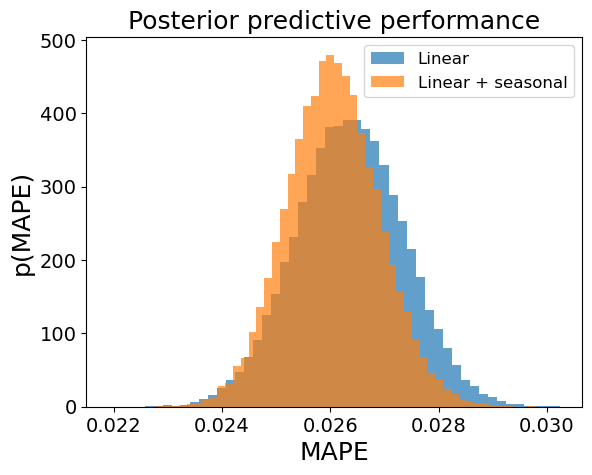

In [71]:
def mape(y_pred_):
    return np.mean(np.abs(y_pred_ - y_test) / y_test)

#
y_predict_samples_seasonal = np.reshape(samples_seasonal["y_predict"], newshape=(-1, num_chains * num_samples))
y_predict_samples_linear = np.reshape(samples_linear["y_predict"], newshape=(-1, num_chains * num_samples))

mape_scores_seasonal = np.apply_along_axis(mape, 1,
                                           y_predict_samples_seasonal.T)
mape_scores_linear = np.apply_along_axis(mape, 1,
                                         y_predict_samples_linear.T)

plt.figure()
plt.hist(mape_scores_linear, density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(mape_scores_seasonal, density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.xlabel('MAPE')
plt.ylabel('p(MAPE)')
plt.title('Posterior predictive performance')
plt.legend();

The parameter $\sigma$ in $y_i \mid \mu_i, \sigma \sim \mathcal{N}(\mu_i, \sigma)$ indicates how much the actual observations vary around the predicted mean.

8. Make a figure with two overlapping histograms again, this time showing the posterior distribution of $\sigma$ according to either the linear, or the linear+seasonal trends. Why is $\sigma$ lower for the linear+seasonal model?

_ANSWER:_ The real date obviously contains a periodic trend. The linear line can not capture this, and has to give an high estimate of its observation noise. If we add a seasonal component, then this added variance of our model captures the underlying variance of the real data better. In a sense, the observation noise $\sigma$ is lower because the variance in the real data is captured by the added seasonal component, thereby increasing the confidence in the models' estimates (== reducing the observation noise).

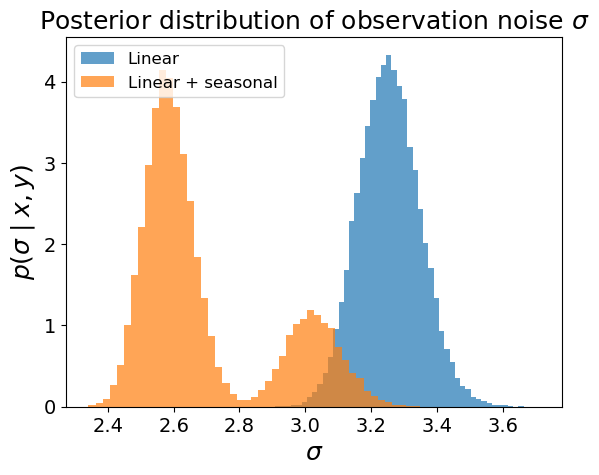

In [72]:
plt.figure()
plt.hist(samples_linear["sigma"].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(samples_seasonal["sigma"].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p({\sigma\mid x}, y)$')
plt.title(r'Posterior distribution of observation noise $\sigma$')
plt.legend();

## The linear + seasonal + quadratic model

Both the MAPE and the posterior distribution of $\sigma$ (and of course the visualization of the predictions themselves) confirm that the seasonal trend is a welcome addition when trying to model the CO2 concentrations in the air around Mauna Loa. However, there's definitely room for improvement still.

By looking at the model fits and predictions, we see that the linear trend works well in the middle of the training range, but is incorrect near the edges (and therefore also near the range we are interested in most; after 2010!). A higher-order trend (like **quadratic**) might be helpful here:

$$
\begin{align*}
    \mu_i \mid \beta_0, \beta_1, \beta_2, \beta_3, \phi x_i &= \beta_0 + \beta_1 x_i + \beta_2 \sin(2\pi / 12 x_i + \phi)  + \beta_3 x_i^2&& i=1,\ldots,n\\
    y_i \mid \mu_i, \sigma & \sim \mathcal{N}(\mu_i, \sigma)  && i=1,\ldots,n\enspace.
\end{align*}
$$

9. Copy your previous JAGS code to the cell below and add the quadratic term. Repeat the steps from before: plot the predictions, plot the MAPE (for all three models in a single figure) and plot the posterior of $\sigma$ (also for all three models in a single figure).

_ANSWER:_

In [73]:
%%time

code = '''
model{
    sigma ~ dunif(0.00001, 500)
    tau <- 1/pow(sigma, 2)
    b[1] ~ dnorm(320, 0.01)  
    b[2] ~ dnorm(2, 0.01)    
    b[3] ~ dnorm(5, 0.01)    
    b[4] ~ dnorm(0, 0.01)
    
    phi ~ dunif(0, 12)       
    
    for (i in 1:n_train) { 
        mu_train[i] <- b[1] + b[2] * x_train[i] + b[3] * sin(2 * 3.1415926535 / 12 * (x_train[i] + phi)) + b[4] * pow(x_train[i], 2)
        y_train[i] ~ dnorm(mu_train[i], tau) 
    }
        
    for (i in 1:n_test) { 
        mu_predict[i] <- b[1] + b[2] * x_test[i] + b[3] * sin(2 * 3.1415926535 / 12 * (x_test[i] + phi)) + b[4] * pow(x_test[i], 2)
        y_predict[i] ~ dnorm(mu_predict[i], tau) 
    }  
}
'''

data = dict(x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            n_train=n_train,
            n_test=n_test)
num_samples = 10_000
num_chains = 4

m_quad = pj.Model(code=code, data=data, chains=num_chains)
samples_quad = m_quad.sample(num_samples, vars=["y_predict", "b", "sigma", "phi"])

adapting: iterations 4000 of 4000, elapsed 0:00:04, remaining 0:00:00
sampling: iterations 8880 of 40000, elapsed 0:00:09, remaining 0:00:32
sampling: iterations 18664 of 40000, elapsed 0:00:19, remaining 0:00:22
sampling: iterations 28536 of 40000, elapsed 0:00:29, remaining 0:00:12
sampling: iterations 33440 of 40000, elapsed 0:00:36, remaining 0:00:07
sampling: iterations 38068 of 40000, elapsed 0:00:46, remaining 0:00:02
sampling: iterations 40000 of 40000, elapsed 0:00:49, remaining 0:00:00
CPU times: user 52.9 s, sys: 108 ms, total: 53 s
Wall time: 53 s


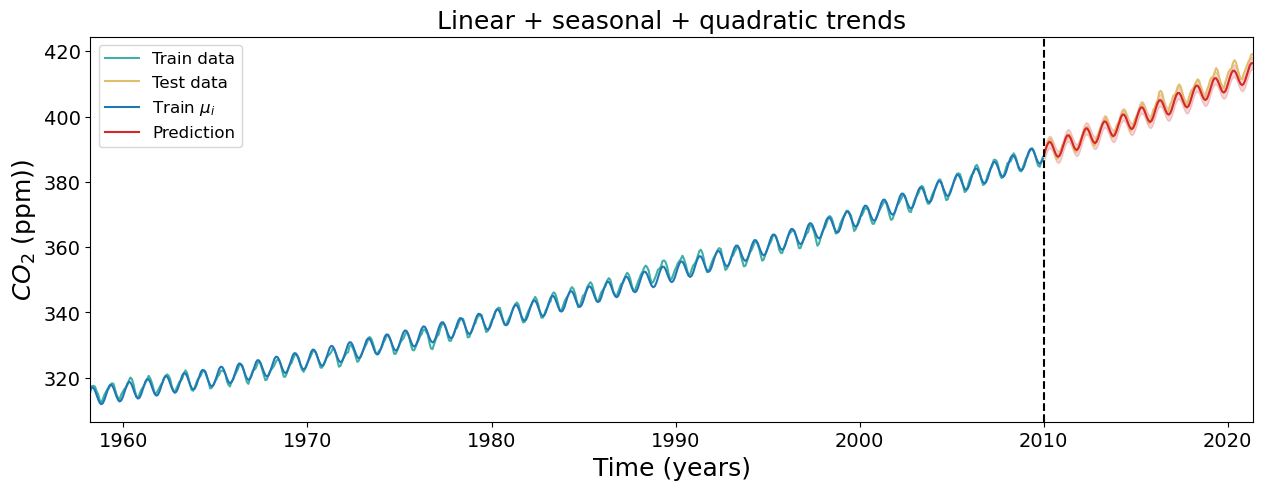

In [74]:
beta0 = samples_quad["b"][0].flatten() # shape num_samples * num_chains
beta1 = samples_quad["b"][1].flatten() # shape num_samples * num_chains
beta2 = samples_quad["b"][2].flatten()
beta3 = samples_quad["b"][3].flatten()
sigma = samples_quad["sigma"].flatten() # shape num_samples * num_chains
phi = samples_quad["phi"].flatten()
angular_freq = 2*3.14159/12
linear_part = beta0[:, np.newaxis] + beta1[:, np.newaxis] * x_train[np.newaxis, :] # shape: num_samples * num_chains x num_train (num_samples * num_chains x 1 + num_samples * num_chains x 1 @ 1 x num_train)
seasonal_part = beta2[:, np.newaxis] * np.sin(angular_freq * (x_train[np.newaxis, :] + phi[:, np.newaxis]))
quadratic_part = beta3[:, np.newaxis] * np.power(x_train[np.newaxis, :], 2)
mu_samples = linear_part + seasonal_part + quadratic_part

mu_exp = mu_samples.mean(axis=0)

y_predict = np.reshape(samples_quad["y_predict"], newshape=(-1, num_samples* num_chains))
y_predict_mean = np.mean(y_predict, axis=-1)
y_predict_lb = np.percentile(y_predict, 2.5, axis=1)  # lower bound of HDI
y_predict_ub = np.percentile(y_predict, 97.5, axis=1)  # upper bound of HDI

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_exp, color='tab:blue',
        label='Train $\mu_i$')
ax.plot(time_test, y_predict_mean, color='tab:red', label='Prediction')
ax.fill_between(time_test, y_predict_lb, y_predict_ub, color='tab:red',
                alpha=0.2)

ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)])
ax.set_title('Linear + seasonal + quadratic trends');

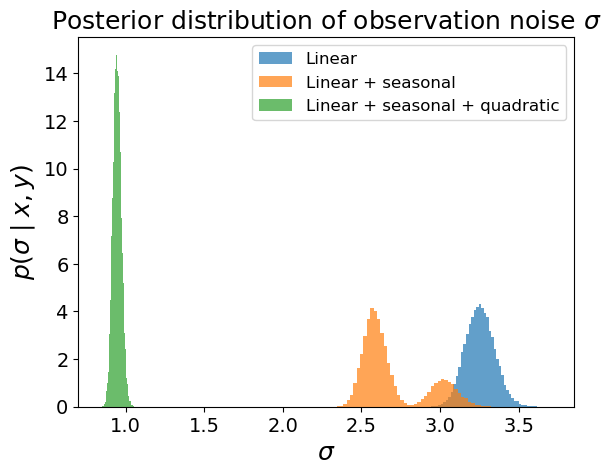

In [75]:
plt.figure()
plt.hist(samples_linear["sigma"].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(samples_seasonal["sigma"].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.hist(samples_quad["sigma"].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear + seasonal + quadratic')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p({\sigma\mid x}, y)$')
plt.title(r'Posterior distribution of observation noise $\sigma$')
plt.legend();

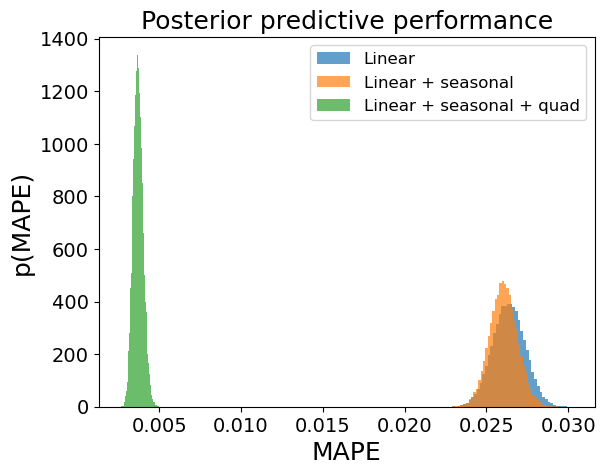

In [76]:
def mape(y_pred_):
    return np.mean(np.abs(y_pred_ - y_test) / y_test)

#
y_predict_samples_quad = np.reshape(samples_quad["y_predict"], newshape=(-1, num_chains * num_samples))
y_predict_samples_seasonal = np.reshape(samples_seasonal["y_predict"], newshape=(-1, num_chains * num_samples))
y_predict_samples_linear = np.reshape(samples_linear["y_predict"], newshape=(-1, num_chains * num_samples))

mape_scores_quad = np.apply_along_axis(mape, 1,
                                           y_predict_samples_quad.T)
mape_scores_seasonal = np.apply_along_axis(mape, 1,
                                           y_predict_samples_seasonal.T)
mape_scores_linear = np.apply_along_axis(mape, 1,
                                         y_predict_samples_linear.T)

plt.figure()
plt.hist(mape_scores_linear, density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(mape_scores_seasonal, density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.hist(mape_scores_quad, density=True, bins=50, alpha=0.7,
         label='Linear + seasonal + quad')
plt.xlabel('MAPE')
plt.ylabel('p(MAPE)')
plt.title('Posterior predictive performance')
plt.legend();

When fitting models to training data, we know that we will always obtain a better fit with a complex model than with a simple one. Our last model is definitely the most complex. For example, the linear model is just a special case of it, with $\beta_2=\beta_3=0$.

We saw in lecture 7 how Bayesian model comparison through Bayes factors / marginal likelihoods has a form of Occam's razor built-in, that adjusts for model complexity. However, here we computed the predictive performance of the models instead (using the MAPE).

10. Argue why we did or did not overfit in this exercise.

_ANSWER:_ I don't think we have overfit in this exercise. One symptome of overftting is that we overfit _to_ the training data, i.e. we overengineer for the training data, but the model doesn't generalize well. However, given that the model holds up well against the test data, we can conclude that we only added _general_ model components to the model (that hold during training data and test data). For example, it is sensible to describe a seasonal component, as CO2 concentrations depend on seasonality. Similarly, it makes sense to add some kind of quadratic growth (or even exponential growth) over time, because of humans causing an increase in anthropogenic CO2 concentration across the world. We should suspect overfitting if we solely described trends that were true for the training data but don't hold up for the test data.


---
# 3. Predicting diabetes

For the final exercise of this assignment we'll be looking into a logistic regression example (see Lecture 06). This is essentially Bayesian classification.

The dataset from this study comes from a Kaggle competition and was collected by the National Institute of Diabetes and Digestive and Kidney Diseases, and contains measurements for $n=768$ women of Pima Indian Heritage. The measurements consist of diagnostic information such as glucose levels, BMI, number of pregnancies, and so forth. Our job is to predict the outcome variable 'diabetes' (0 for no, 1 for yes) based on these predictors, and to figure out which variables are most important for this diagnosis.

The code block below loads the data and does some minor preprocessing so the data are 'nice' to work with.

Note: This is a relatively large dataset, which means that a JAGS model might run for quite a while. For debugging, you can just use the first $m \ll n$ records of course!

In [ ]:
def zscale(x):
    return (x - np.mean(x)) / np.std(x)

#

# Load dataset
df = pd.read_csv('diabetes.csv', sep=',', header=0)

# We have some missing values; glucose, blood pressure, skin thickness, insulin, BMI, DiabetesPedigreeFunction contain zeros which is impossible
# We fill in these missing values by *imputing* the median

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']:
    df[col] = df[col].replace(0, df[col].median())

# Since the predictors are measured in different units, we rescale them so we can interpret the corresponding coefficients later on

for col in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']:
    df[col] = zscale(df[col])

df['Age'] = df['Age'] / 100

# The predictors in numpy format:
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].to_numpy()

# And the outcome that we will try to predict
y = df['Outcome']

n, p = X.shape

# split train/test

train_fraction = 0.8
n_train = int(n*train_fraction)
n_test = n - n_train

X_train = X[0:n_train, :]
y_train = y[0:n_train]

X_test = X[n_train:, :]
y_test = y[n_train:]

The code above also splits the data into a set for training and a set for testing; that will tell us how well our model generalizes to new observations.

1. Implement a logistic regression model in JAGS and train it on the training data `X_train` and `y_train`. Don't forget to include an intercept term $\beta_0$!

In [30]:
model = '''
model {
    # Prior
    w0 ~ dnorm (0,1)
    for (i in 1:n_features) {
        w[i] ~ dnorm(0,1)
    }
    
    # Likelihood
    for (j in 1:n_samples) {
        theta[j] <- ilogit (w0 + inprod(w[], X_train[j,]))
        y_train[j] ~ dbern(theta[j])
    }
}

'''

data = dict(
    n_features=X_train.shape[1],
    n_samples = X_train.shape[0],
    X_train=X_train,
    y_train=y_train
)

# How long we sample
num_iter = 20_000
# How many distinct sampling runs
num_chains = 4

model = pj.Model(model, data=data, chains=num_chains)
samples = model.sample(num_iter, vars=["w0", "w", "theta"])

adapting: iterations 2772 of 4000, elapsed 0:00:07, remaining 0:00:03
adapting: iterations 4000 of 4000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 1996 of 80000, elapsed 0:00:07, remaining 0:04:46
sampling: iterations 3356 of 80000, elapsed 0:00:13, remaining 0:05:07
sampling: iterations 5892 of 80000, elapsed 0:00:21, remaining 0:04:29
sampling: iterations 8712 of 80000, elapsed 0:00:29, remaining 0:03:55
sampling: iterations 11788 of 80000, elapsed 0:00:36, remaining 0:03:30
sampling: iterations 15068 of 80000, elapsed 0:00:45, remaining 0:03:12
sampling: iterations 18456 of 80000, elapsed 0:00:56, remaining 0:03:05
sampling: iterations 20112 of 80000, elapsed 0:01:01, remaining 0:03:02
sampling: iterations 21756 of 80000, elapsed 0:01:06, remaining 0:02:57
sampling: iterations 23396 of 80000, elapsed 0:01:12, remaining 0:02:54
sampling: iterations 25016 of 80000, elapsed 0:01:19, remaining 0:02:54
sampling: iterations 26592 of 80000, elapsed 0:01:25, remaining 0:02:51


2. Make a figure showing for all predictors a histogram of the distribution and the 95% HDI interval indicated as a shaded area (for an example, see slide 45 in Lecture 06). Using the standard approach from the course, which predictors are important in predicting whether someone will have diabetes?

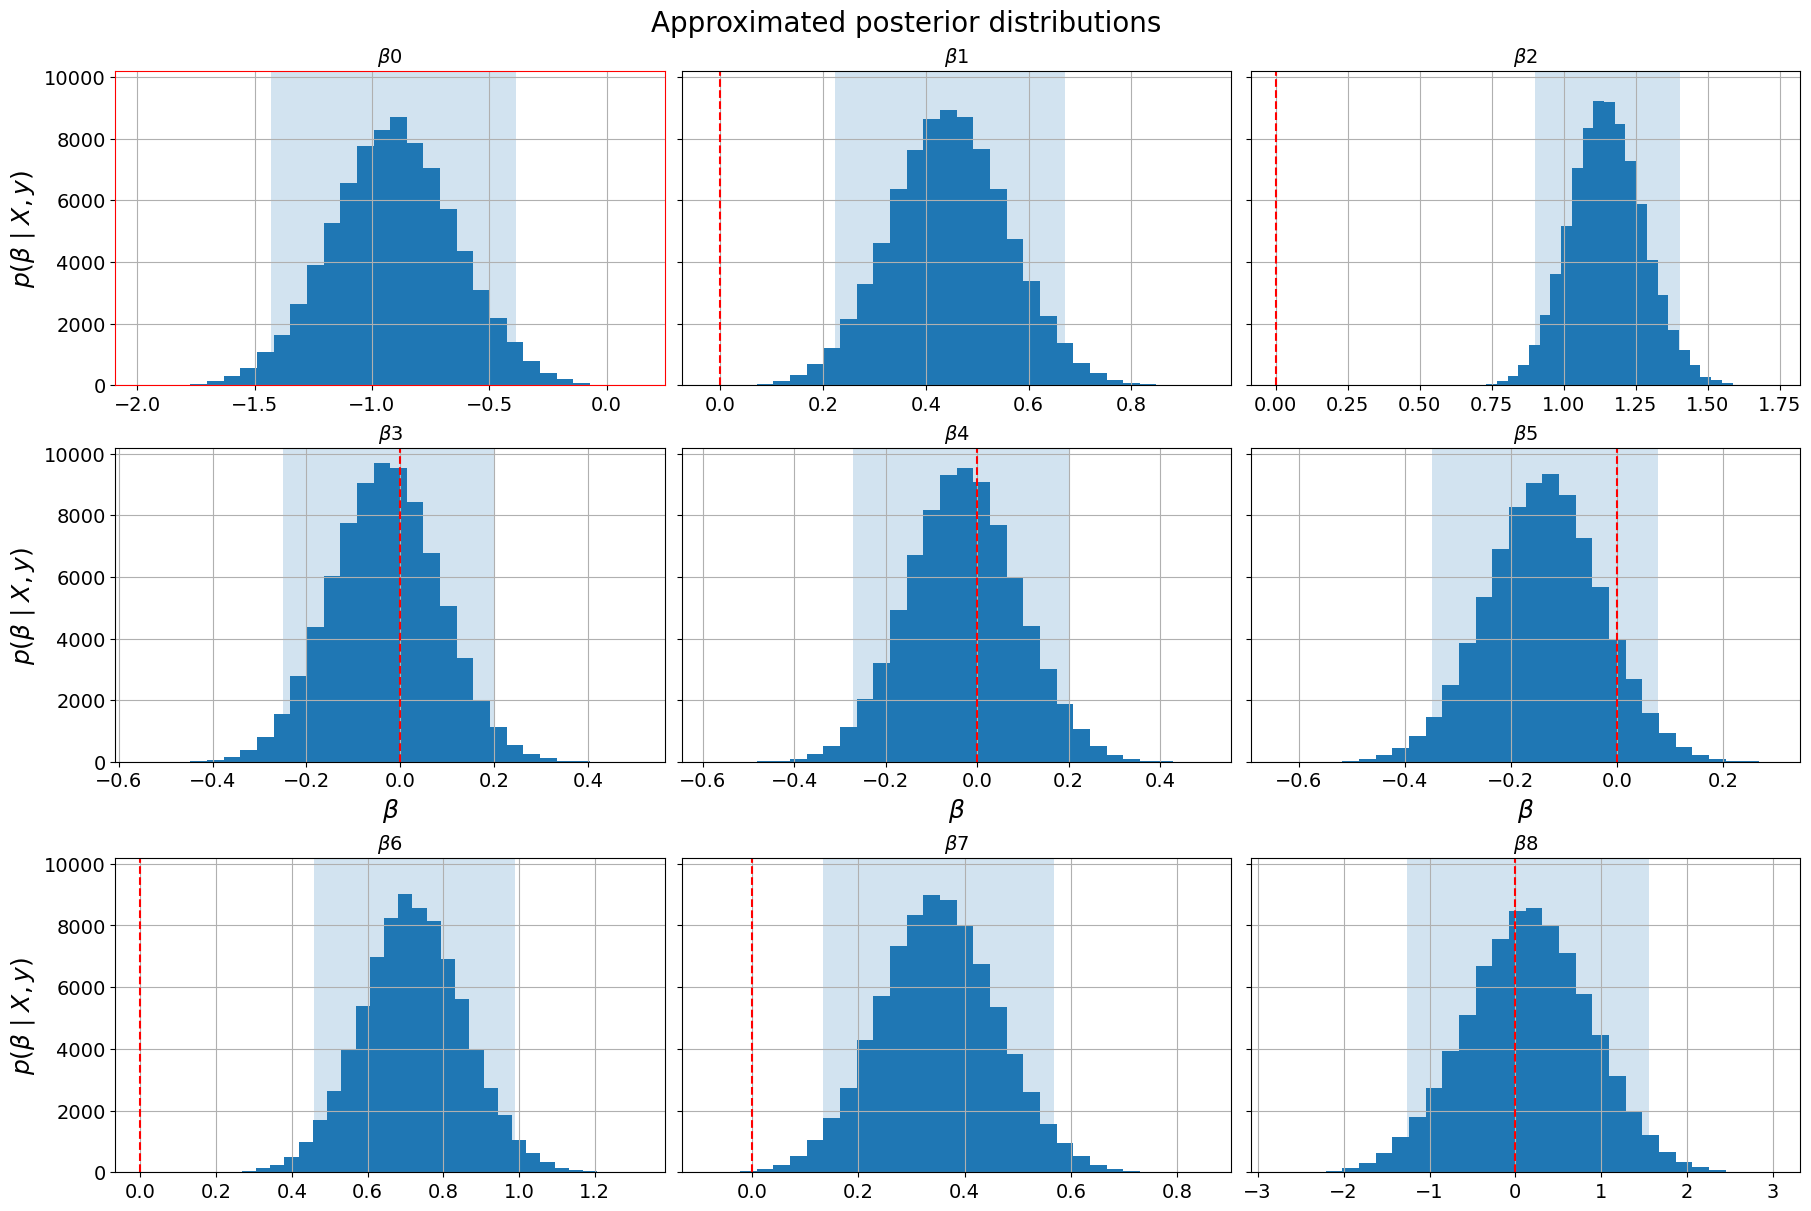

In [39]:
def get_hdi(s, intv=0.95):
    s_sorted = np.sort(s)
    n = len(s_sorted)
    num_samples_in_hdi = int(n * intv)
    num_possible_hdis = n - num_samples_in_hdi 

    bottom_idx = np.arange(0, num_possible_hdis)
    top_idx = bottom_idx + num_samples_in_hdi

    assert all(top_idx - bottom_idx == num_samples_in_hdi)

    s_bottom = s_sorted[bottom_idx]
    s_top = s_sorted[top_idx]
    diffs = s_top - s_bottom
    min_diff_idx = np.argmin(diffs)

    s_bottom_hdi = s_bottom[min_diff_idx]
    s_top_hdi = s_top[min_diff_idx]
    
    return s_bottom_hdi, s_top_hdi

w0 = samples["w0"].flatten()
w = np.reshape(samples["w"], newshape=(-1, num_chains*num_iter))
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, constrained_layout=True, 
                       figsize=(18, 12))

for i, ax in enumerate(axes.flatten()):
    if i == 0:
        hdi_bottom, hdi_top = get_hdi(w0)
        ax.hist(w0, bins=30)
        ax.axvspan(hdi_bottom, hdi_top, alpha=0.2)
    else:
        hdi_bottom, hdi_top = get_hdi(w[i-1, :])
        ax.hist(w[i-1, :], bins=30)
        ax.axvspan(hdi_bottom, hdi_top, alpha=0.2)
        ax.axvline(0, color='red', linestyle='--')

    ax.grid(True)
    ax.set_title(rf"$\beta${i}", fontsize=14)
for ax in axes[1, :]:
    ax.set_xlabel(r'$\beta$')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$p(\beta \mid X, y)$')

ax = axes.flatten()[0]
for _, spine in ax.spines.items():
    spine.set_color('red')    
    spine.set_color('red')
    
plt.suptitle('Approximated posterior distributions', fontsize=20);

_ANSWER_: As in assignment 2, we regard predictors who's HDI contain the value 0.0 as unimportant. If a predictor is predominantly 0.0, this would mean that a given feature is not relevant for predictor. This is the case $\beta_3, \beta_4, \beta_5, \beta_8$. Therefore, $\beta_1, \beta_2, \beta_6, \beta_7$ are important predictors for predicting diabetes. As usual, it is hard to interpret the intercept $\beta_0$, since it is not directly multiplying a given feature, but describes the initial guess, if all features are 0. 

Now let's see how well our model can predict diabetes for data it has not yet seen.

We can do this via the posterior predictive distribution $p(y^* \mid \mathbf{y})$, but because this distribution includes all the uncertainty of our parameters, plus the uncertainty of the predictive distribution, it is very wide. If we sample a prediction from such a wide distribution, it will often be wrong, because of this width.

If we just want to look at the performance of the logistic regression model as a classifier, it is helpful to summarize the distributions of the regression parameters with their expectation instead. As you recall, you can obtain these by simply taking the mean over your samples.

Compute the mean of your model parameters (intercept and coefficients) and using those means, compute for every test individual $i$ (with predictors $\mathbf{x}_i^*) $the probability
$$
\mu_i^*= p(y_i^* =1 \mid \mathbf{y}) = \text{logit}^{-1}\left( \bar{\beta}_0 + \bar{\mathbf{\beta}}(\mathbf{x}_i^*)^\top\right)
$$ where the bar symbol $\bar{\cdot}$ indicates the posterior mean of those parameters.

Now $\mu_i^*$ is the probability that  $y_i^*=1$, so we can apply a threshold to obtain an actual prediction. Let's say the predictions are $y_i^* = \mu_i^* > 0.5$.

3. Use these predictions as the output of your Bayesian classifier. What is the accuracy of this tool?

In [50]:
from scipy.special import expit
w0_exp = np.mean(w0)
w_exp = np.mean(w, axis=-1)
preds = (expit(w0_exp + np.matmul(w_exp, X_test.T)) > 0.5).astype(int) # (1,) + (8,)*(N, 8).T
acc = np.mean(preds == y_test)


_ANSWER_: The accuracy is $\approx 0.75$, i.e. 75% of cases are correctly identified.